# CNN using Tensorflow Keras on MRI Image Data - failed attempt (memory out)

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

## Setup

### General Imports

In [1]:
import nibabel.freesurfer.mghformat as mgh

from tqdm.notebook import tqdm

import os, sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
pd.set_option('display.max_colwidth', None)

### Set up and test Tensorflow

In [2]:
import tensorflow as tf

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensor Flow Version: 2.2.0
Keras Version: 2.3.0-tf

Python 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Pandas 1.2.4
Num GPUs Available:  1


In [4]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Load data

### CSV

In [5]:
rootdir = '/home/jack/Code/GitHub/Polygence/'
df = pd.read_csv(rootdir + 'Data/OASIS/csv_files/oasis_3.csv')
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


In [6]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'FS ID', 'dx1':'Diagnosis'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit
df = df.reset_index(drop=True) # Reset the index
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
# df['Diagnosis'].replace(['control','dementia'], [-1,1], inplace=True)
df = df.drop(df.columns.difference(['Subject', 'MR ID', 'FS ID', 'Diagnosis']), axis=1) # Drop all columns unless needed
print(df.shape)

(1022, 4)


In [7]:
df.head()

,Subject,MR ID,FS ID,Diagnosis
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,control
1,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,control
2,OAS30003,OAS30003_MR_d2682,OAS30003_Freesurfer53_d2682,control
3,OAS30004,OAS30004_MR_d2232,OAS30004_Freesurfer53_d2232,control
4,OAS30005,OAS30005_MR_d2377,OAS30005_Freesurfer53_d2377,control


<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

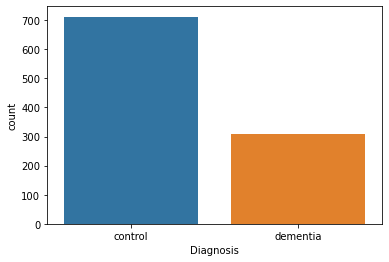

In [8]:
sns.countplot(x='Diagnosis', data=df)

### MRI
Since all the files are already transformed via the freesurfer, I don't think we'll need to do any major preprocessing like cropping, flipping, or rotating.
```
main_directory/
    control/
        mr_id_001/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
        mr_id_002/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
    dementia/
        mr_id_003/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
        mr_id_004/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
```

#### Flags

In [9]:
# This class allows you to access dictionary items with a dot
# Gathered from here: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [10]:
FLAGS = {
    'scan_width'  : 256,
    'scan_height' : 256,
    'scan_depth'  : 256,
    'data_dir'    : '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data',
    'num_class'   : 4
}
FLAGS = dotdict(FLAGS)
print(FLAGS)

{'scan_width': 256, 'scan_height': 256, 'scan_depth': 256, 'data_dir': '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data', 'num_class': 4}


#### Create a list of filenames

In [11]:
def generate_filenames(labels=['control', 'dementia'], random_state=1337):
    filenames = []
    
    for label in labels:
        label_dir = os.path.join(FLAGS.data_dir, label)
        mr_ids = os.listdir(label_dir)
        mr_ids.sort()
        
        for mr_id in tqdm(mr_ids, desc=label):
            scans = os.path.join(label_dir, mr_id)
            img_file = [file for file in os.listdir(scans) if "transformed" in file]
            img_path = os.path.join(scans, img_file[0])
            i = 1 if label == 'dementia' else 0
            filenames.append([img_path, i])
            
    random.Random(random_state).shuffle(filenames)
    
    return filenames

fnames = generate_filenames(random_state=1337)

control:   0%|          | 0/712 [00:00<?, ?it/s]

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

In [12]:
for i in range(5):
    print(fnames[i])

['/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30011_MR_d1671/OAS30011_Freesurfer53_d1671_brain_transformed.mgz', 0]
['/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30779_MR_d0065/OAS30779_Freesurfer53_d0065_brain_transformed.mgz', 1]
['/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30872_MR_d3057/OAS30872_Freesurfer53_d3057_brain_transformed.mgz', 0]
['/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30736_MR_d3151/OAS30736_Freesurfer50_d3151_brain_transformed.mgz', 0]
['/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30119_MR_d3260/OAS30119_Freesurfer53_d3260_brain_transformed.mgz', 1]


In [13]:
# Validate that the filename and labels are correct
for item in fnames:
    if 'control' in item[0] and item[1] != 0:
        print("bad")
    if 'dementia' in item[0] and item[1] != 1:
        print("bad")

#### Generate the MRI data, given a batch size

In [14]:
batch_index = 0
def get_mri_data(filenames, batch_size=5, random_state=1337):
    global batch_index
    
    limit = len(filenames)
    
    start = batch_index
    end = batch_size + batch_index
    
    if end >= limit:
        end = limit
        batch_index = 0
    
    X_data = []  # this will contain the data of the MRI scans
    y_data = np.zeros((batch_size)  # this will store the labels
    
    def normalize(volume):
        """ Normalize the volume """
        min = 0.0
        max = 255.0
        volume[volume < min] = min
        volume[volume > max] = max
        volume = (volume - min) / (max - min)
        volume = volume.astype("float32")
        return volume

    
    for i in range(start, end):
        MRI_orig = mgh.load(fnames[i][0])
        MRI_data = MRI_orig.get_fdata()
        rem_fs = str(fnames[i][0])[:fnames[i][0].rfind("/")]
        rem_mr = rem_fs[:rem_fs.rfind("/")]
        print(str(rem_mr[rem_mr.rfind("/")+1:] + str(fnames[i][0])[fnames[i][0].rfind("/"):]), MRI_data.shape, type(MRI_data))
        
        MRI_data = normalize(MRI_data)
        
        # I don't need to resize bc we already did it with the Freesurfer talairach thing
        # resized = tf.image.resize(MRI_data, (FLAGS.scan_width, FLAGS.scan_height))
        
        X_data.append(MRI_data)
        y_data[i] = fnames[i][1]
        
    return X_data, y_data

#### Example batch visualizations

In [15]:
nrows = 6
ncols = 4

ex_ctrls = []
ex_dems = []
for path, label in fnames:
    if len(ex_ctrls) >= 4 and len(ex_dems) >= 4:
        break
    if label == 0:
        if len(ex_ctrls) < 4:
            ex_ctrls.append(path)
    else:
        if len(ex_dems) < 4:
            ex_dems.append(path)

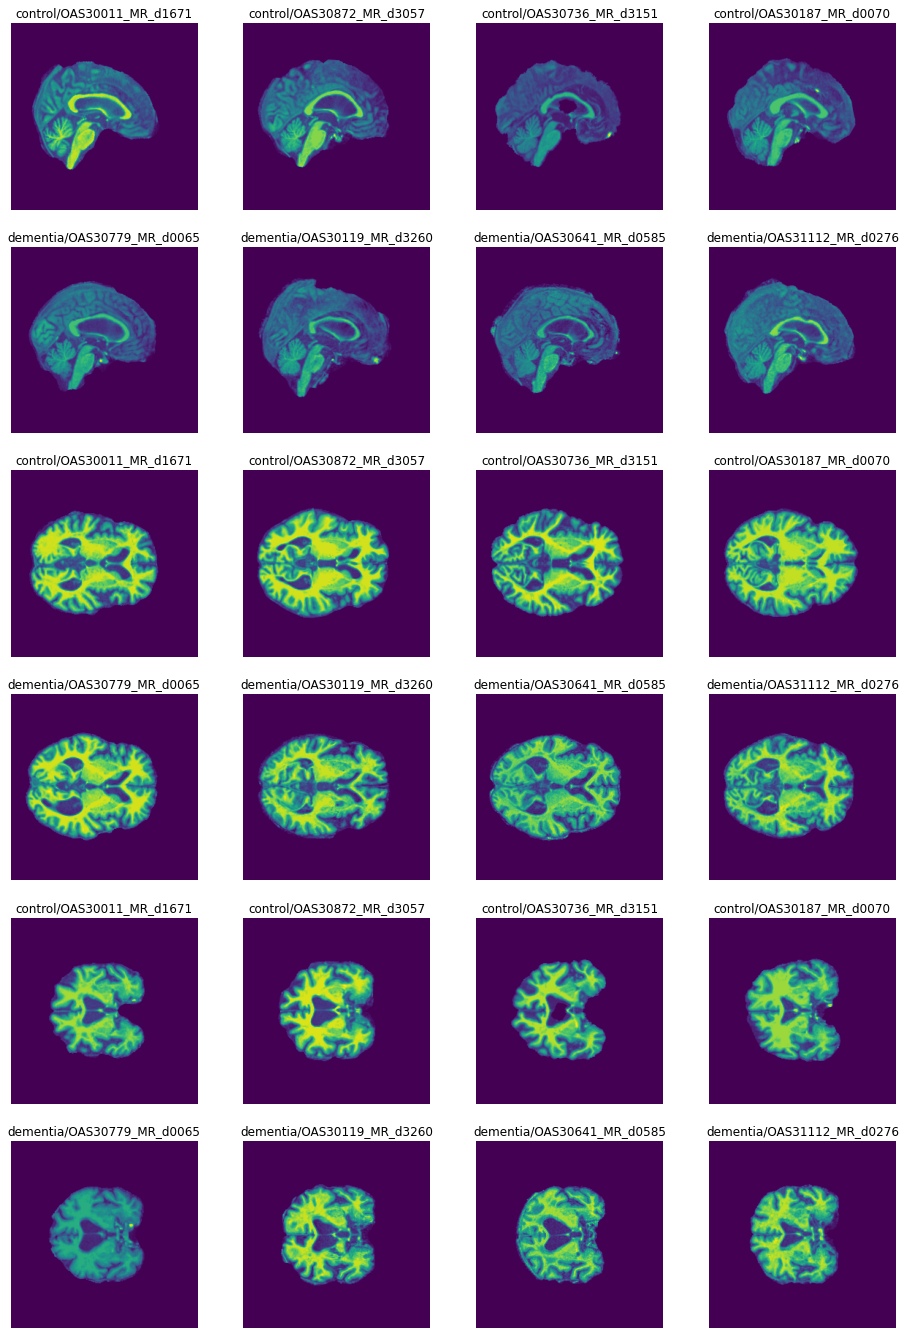

In [16]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

idx = 1
for i, path in enumerate(ex_ctrls + ex_dems):
    sp = plt.subplot(nrows, ncols, idx)
    idx += 1
    sp.axis('Off')
    
    MRI_orig = mgh.load(path)
    MRI_data = MRI_orig.get_fdata()
    rem_fs = path[:path.rfind("/")]
    sp.set_title(rem_fs[rem_fs[:rem_fs.rfind("/")].rfind("/")+1:])
    
    plt.imshow(MRI_data[128, :, :])
    
for i, path in enumerate(ex_ctrls + ex_dems):
    sp = plt.subplot(nrows, ncols, idx)
    idx += 1
    sp.axis('Off')
    
    MRI_orig = mgh.load(path)
    MRI_data = MRI_orig.get_fdata()
    rem_fs = path[:path.rfind("/")]
    sp.set_title(rem_fs[rem_fs[:rem_fs.rfind("/")].rfind("/")+1:])
    
    plt.imshow(MRI_data[:, 128, :])
    
for i, path in enumerate(ex_ctrls + ex_dems):
    sp = plt.subplot(nrows, ncols, idx)
    idx += 1
    sp.axis('Off')
    
    MRI_orig = mgh.load(path)
    MRI_data = MRI_orig.get_fdata()
    rem_fs = path[:path.rfind("/")]
    sp.set_title(rem_fs[rem_fs[:rem_fs.rfind("/")].rfind("/")+1:])
    
    plt.imshow(MRI_data[:, :, 128])